In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from matplotlib import pyplot as plt 
import sklearn
from sklearn.model_selection import train_test_split

## IMPORT & EXPLORE

#### FUNCTIONS

In [31]:
def generate_augmented_images(images, labels, augmentations_per_image=3, zoom_range=(0.9, 1.1)):
    augmented_images = []
    augmented_labels = []
    
    # Precompute random values for efficiency
    num_total_augs = len(images) * augmentations_per_image
    random_flips_lr = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_flips_ud = tf.random.uniform([num_total_augs], 0, 2, dtype=tf.int32)
    random_rotations = tf.random.uniform([num_total_augs], 0, 4, dtype=tf.int32)
    random_brightness = tf.random.uniform([num_total_augs], -0.1, 0.1)
    random_contrasts = tf.random.uniform([num_total_augs], 0.8, 1.2)
    zoom_factors = tf.random.uniform([num_total_augs], zoom_range[0], zoom_range[1])
    
    # Process images in batches if possible
    aug_idx = 0
    for img, lbl in zip(images, labels):
        # Ensure image is properly shaped for grayscale (h, w, 1)
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)
        
        h, w, c = img.shape
        
        for _ in range(augmentations_per_image):
            # Use precomputed random values
            aug_img = img
            
            # Apply random horizontal flip
            if random_flips_lr[aug_idx] > 0:
                aug_img = tf.image.flip_left_right(aug_img)
            
            # Apply random vertical flip
            if random_flips_ud[aug_idx] > 0:
                aug_img = tf.image.flip_up_down(aug_img)
            
            # Apply random rotation (90-degree increments)
            aug_img = tf.image.rot90(aug_img, k=random_rotations[aug_idx])
            
            # Apply random brightness (grayscale-appropriate)
            aug_img = tf.image.adjust_brightness(aug_img, random_brightness[aug_idx])
            
            # Apply random contrast (grayscale-appropriate)
            aug_img = tf.image.adjust_contrast(aug_img, random_contrasts[aug_idx])
            
            # Gaussian noise - optimized for grayscale
            if tf.random.uniform(()) > 0.7:  # Apply with 30% probability
                noise = tf.random.normal(shape=tf.shape(aug_img), mean=0.0, stddev=0.05)
                aug_img = tf.clip_by_value(aug_img + noise, 0.0, 1.0)
            
            # Random zoom with the corrected logic
            zoom_factor = zoom_factors[aug_idx]
            
            if zoom_factor > 1.0:  # Zoom in
                new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
                top = (h - new_h) // 2
                left = (w - new_w) // 2
                aug_img = tf.image.crop_to_bounding_box(aug_img, top, left, new_h, new_w)
                aug_img = tf.image.resize(aug_img, (h, w))
            else:  # Zoom out
                new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
                aug_img = tf.image.resize(aug_img, (new_h, new_w))
                aug_img = tf.image.resize_with_crop_or_pad(aug_img, h, w)
            
            # Random grayscale-specific transformations:
            
            # 1. Random gamma adjustment (especially useful for grayscale)
            if tf.random.uniform(()) > 0.7:
                gamma = tf.random.uniform([], 0.8, 1.2)
                aug_img = tf.image.adjust_gamma(aug_img, gamma)
            
            # 2. Random cutout (masking) - optimized version
            if tf.random.uniform(()) > 0.8:  # Apply with 20% probability
                mask_size_h = tf.cast(h * tf.random.uniform([], 0.1, 0.2), tf.int32)
                mask_size_w = tf.cast(w * tf.random.uniform([], 0.1, 0.2), tf.int32)
                mask_y = tf.random.uniform([], 0, h - mask_size_h, dtype=tf.int32)
                mask_x = tf.random.uniform([], 0, w - mask_size_w, dtype=tf.int32)
                
                # More efficient cutout implementation for grayscale
                mask = tf.zeros([mask_size_h, mask_size_w, 1]) + 0.5  # Gray mask
                paddings = [[mask_y, h - mask_y - mask_size_h], 
                            [mask_x, w - mask_x - mask_size_w], 
                            [0, 0]]
                mask = tf.pad(mask, paddings)
                mask = tf.cast(mask > 0, aug_img.dtype)
                aug_img = aug_img * (1 - mask) + mask * 0.5
            
            # Append the augmented image
            augmented_images.append(aug_img.numpy())
            augmented_labels.append(lbl)
            aug_idx += 1
    
    return np.array(augmented_images), np.array(augmented_labels)

Here , i added more transformation to improve generalization

In [10]:
def display_examples(images, labels, num_examples=5):
    plt.figure(figsize=(10, 10))
    
    for i in range(num_examples):
        ax = plt.subplot(1, num_examples, i + 1)
        ax.imshow(images[i])  # Display the image
        ax.set_title(f"Label: {labels[i]}")  # Display the label
        ax.axis("off")  # Hide axes
    
    plt.show()

#### IMAGES

In [32]:
lung_xray_scans = np.load(r"C:\Users\User\Desktop\DATA SCIENCE\Projects\XrayCT-Disease-Detection\data\tuberculosis\tuberculosis_detection.npz")['images']
lung_xray_scans_labels = np.load(r"C:\Users\User\Desktop\DATA SCIENCE\Projects\XrayCT-Disease-Detection\data\tuberculosis\tuberculosis_detection.npz")['labels']

## CLEAN & PREPARE

#### PREPARE DATA FOR MODEL BUILDING

In [34]:
lung_xray_scans , lung_xray_scans_labels = generate_augmented_images(images = lung_xray_scans,
                                                                     labels = lung_xray_scans_labels,
                                                                     augmentations_per_image = 2)

In [35]:
lung_xray_scans.shape

(12600, 224, 224, 1)

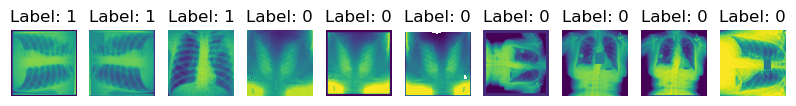

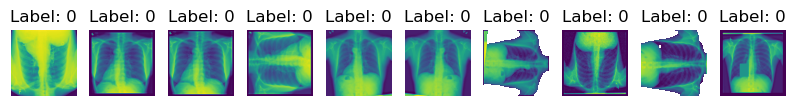

In [40]:
display_examples(images = lung_xray_scans[75:],
                 labels = lung_xray_scans_labels[75:],
                 num_examples=10)

display_examples(images = lung_xray_scans[95:],
                 labels = lung_xray_scans_labels[95:],
                 num_examples=10)

In [41]:
lung_xray_scans_train , lung_xray_scans_test , lung_xray_scans_labels_train , lung_xray_scans_labels_test = train_test_split(
    lung_xray_scans ,
    lung_xray_scans_labels ,
    train_size = 0.95,
    stratify = lung_xray_scans_labels ,
    random_state = 42
)

lung_xray_scans_train , lung_xray_scans_validation , lung_xray_scans_labels_train , lung_xray_scans_labels_validation = train_test_split(
    lung_xray_scans_train ,
    lung_xray_scans_labels_train ,
    train_size = 0.95,
    stratify = lung_xray_scans_labels_train ,
    random_state = 42
)

In [17]:
print(f'IMAGE ARRAYS SHAPES (TRAIN - TEST - VALIDATION) : {lung_xray_scans_train.shape , lung_xray_scans_test.shape , lung_xray_scans_validation.shape }')

IMAGE ARRAYS SHAPES (TRAIN - TEST - VALIDATION) : ((11371, 224, 224, 1), (630, 224, 224, 1), (599, 224, 224, 1))


## MODEL BUILD

In [42]:
from tensorflow.keras import models , layers , optimizers , losses , callbacks 

#### STRUCTURE

In [19]:
lung_xray_scans_sequential_neural_net = models.Sequential( [
   
    layers.Conv2D( filters = 32 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D( filters = 64 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 128 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization(),

    layers.Conv2D( filters = 256 ,
                   kernel_size = (3,3),
                   activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.BatchNormalization()
    
] )

In [20]:
lung_xray_scans_sequential_neural_net.add( layers.GlobalAveragePooling2D() )

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 128 ,
                                                         activation = 'relu') )

lung_xray_scans_sequential_neural_net.add( layers.Dropout(rate = 0.5) ) ,

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 256 ,
                                                         activation = 'relu') ) 

lung_xray_scans_sequential_neural_net.add( layers.Dense( units = 1 ,
                                                         activation = 'sigmoid') )

In [21]:
lung_xray_scans_sequential_neural_net.build( input_shape = (lung_xray_scans.shape) ) 

In [22]:
lung_xray_scans_sequential_neural_net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (12600, 222, 222, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (12600, 111, 111, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (12600, 111, 111, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (12600, 109, 109, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (12600, 54, 54, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (12600, 54, 54, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (12600, 52, 52, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (12600, 26, 26, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (12600, 26, 26, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (12600, 24, 24, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (12600, 12, 12, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (12600, 12, 12, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (12600, 256)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (12600, 128)           │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (12600, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (12600, 256)           │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (12600, 1)             │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,937 (1.74 MB)

 Trainable params: 454,977 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

#### COMPILE

In [23]:
lung_xray_scans_sequential_neural_net.compile( optimizer = optimizers.Adam() ,
                                               loss = losses.BinaryCrossentropy(),
                                               metrics = ['accuracy'] )

lung_xray_scans_sequential_neural_net_early_stop = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                            patience = 25 ,
                                                                            restore_best_weights = True )

#### TRAIN

In [29]:
training_history = lung_xray_scans_sequential_neural_net.fit( lung_xray_scans_train,
                                                              lung_xray_scans_labels_train,
                                                              validation_data = [lung_xray_scans_validation,
                                                                                 lung_xray_scans_labels_validation],
                                                              epochs = 120,
                                                              callbacks = [lung_xray_scans_sequential_neural_net_early_stop],
                                                              verbose = 1,
                                                              batch_size = 32 )

Epoch 1/120
  3/213 ━━━━━━━━━━━━━━━━━━━━ 2:09 617ms/step - accuracy: 0.6128 - loss: 0.6546

KeyboardInterrupt: 